In [4]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-06-29T15:31:55.794 (PT)


In [5]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [6]:
# Import Libraries
using Turing
using Turing: Variational
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import StatsBase.countmap
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

In [7]:
# DP GMM model under CRP construction
@model dp_gmm_crp(y) = begin
    nobs = length(y)
    
    alpha ~ Gamma(1, 1/10)  # mean = 0.1
    rpm = DirichletProcess(alpha)
    
    Hmu = Normal(0, 3)
    Hsig = Gamma(1, 1/10)
    
    # Latent assignment.
    z = tzeros(Int, nobs)
    
    # Locations of the infinitely many clusters.
    mu = tzeros(Float64, 0)
    
    # Scales of the infinitely many clusters.
    sigma = tzeros(Float64, 0)
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        n = Vector{Int}(map(k -> sum(z .== k), 1:K))
        
        z[i] ~ ChineseRestaurantProcess(rpm,  n)
        
        # Create a new cluster?
        if z[i] > K
            push!(mu, 0.0)
            push!(sigma, 1.0)

            # Draw location of new cluster.
            mu[z[i]] ~ Hmu
            sigma[z[i]] ~ Hsig  # shape, scale
        end 
        
        y[i] ~ Normal(mu[z[i]], sigma[z[i]])
    end
end
;

In [8]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n200.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.220078, 0.291918, 0.2498, 0.238204]
  :mu       => Any[-1.47027, -0.46176, 0.440237, 1.49896]
  :sig      => Any[0.148861, 0.121097, 0.195192, 0.19999]
  :y        => Any[-0.643664, -0.506898, -0.616358, -1.37424, -0.230964, -1.706…
  :rand_idx => Any[2, 2, 2, 1, 2, 1, 4, 4, 2, 4  …  3, 2, 4, 1, 3, 4, 2, 2, 2, …

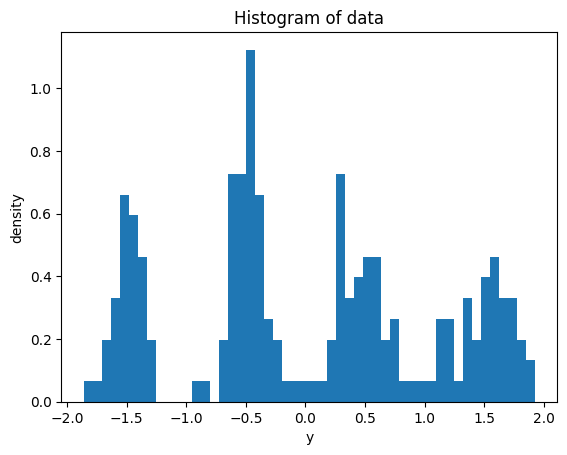

In [9]:
# Convert data to vector of floats
y = Float64.(data[:y]);

# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [10]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [11]:
# Set random seed for reproducibility
Random.seed!(5);

# Compile time approx. 32s.
# Run time approx. 70s

@time crp_chain = begin
    burn = 0  # NOTE: The burn in is also returned. Can't be discarded.
    n_samples = 4
    iterations = burn + n_samples

    sample(dp_gmm_crp(y), SMC(), iterations)
end;

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


 22.371845 seconds (52.30 M allocations: 2.705 GiB, 4.81% gc time)


In [12]:
mupost = extract(crp_chain, :mu, burn=burn)
sigpost = extract(crp_chain, :sigma, burn=burn)
# alphapost = extract(crp_chain, :alpha, burn=burn)
zpost = extract(crp_chain, :z, burn=burn)

# vpost = extract(crp_chain, :v, burn=burn)
# etapost = hcat([BnpUtil.stickbreak(vpost[row, :]) for row in 1:size(vpost, 1)]...)';
# mupost = extract(crp_chain, :mu, burn=burn)
# sigpost = extract(crp_chain, :sig, burn=burn)
# alphapost = extract(crp_chain, :alpha, burn=burn)
# 
# plt.subplot(2, 2, 1)
# plt.boxplot(etapost, whis=[2.5, 97.5], showmeans=true, showfliers=false);
# plt.subplot(2, 2, 2)
# plt.boxplot(mupost, whis=[2.5, 97.5], showmeans=true, showfliers=false);
# plt.subplot(2, 2, 3)
# plt.boxplot(sigpost, whis=[2.5, 97.5], showmeans=true, showfliers=false);
# plt.subplot(2, 2, 4)
# plt.hist(alphapost);
# 
# # plt.plot(sum(etapost .> 1e-2, dims=2))
# # plt.hist(sum(etapost .> 1e-2, dims=2));
# k = map(t -> length(unique(zpost[t, :])), 1:iterations);
# plt.plot(k);

[length(unique(zpost[i, :])) for i in 1:size(zpost, 1)]

4-element Array{Int64,1}:
 1
 1
 1
 1

In [13]:
# FIXME: Not working???

@model infiniteGMM(x) = begin
    nobs = length(x)
    
    # Hyper-parameters, i.e. concentration parameter and parameters of H.
    alpha = 1.0
    mu0 = 0.0
    sig0 = 1.0
    
    # Define random measure, e.g. Dirichlet process.
    rpm = DirichletProcess(alpha)
    
    # Define the base distribution, i.e. expected value of the Dirichlet process.
    H = Normal(mu0, sig0)
    
    # Latent assignment.
    z = tzeros(Int, nobs)
        
    # Locations of the infinitely many clusters.
    mu = tzeros(Float64, 0)
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        nk = Vector{Int}(map(k -> sum(z .== k), 1:K))

        # Draw the latent assignment.
        z[i] ~ ChineseRestaurantProcess(rpm, nk)
        
        # Create a new cluster?
        if z[i] > K
            push!(mu, 0.0)

            # Draw location of new cluster.
            mu[z[i]] ~ H
        end
                
        # Draw observation.
        x[i] ~ Normal(mu[z[i]], 1.0)
    end
end

Random.seed!(1)
data = vcat(randn(10), randn(10) .- 5, randn(10) .+ 10)
data .-= mean(data)
data /= std(data);

Random.seed!(2)
iterations = 1000
model_fun = infiniteGMM(data)
chain = sample(model_fun, SMC(), iterations)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [14]:
x =  [1,3,3,1]
map(k -> sum(x .== k), 1:3)

3-element Array{Int64,1}:
 2
 0
 2

In [15]:
# Fit DP-SB-GMM with NUTS

# Set random seed for reproducibility
Random.seed!(0);

# NUTS
# Compile time approx. 11s
# Run time approx. 244s
# Slower, but works a little better.
@time chain = begin
    n_components = 10
    n_samples = 500
    nadapt = 500
    iterations = n_samples + nadapt
    burn = 0  # For compatibility with HMC below.
    target_accept_ratio = 0.8
    
    sample(dp_gmm_sb(y, n_components),
           NUTS(nadapt, target_accept_ratio, max_depth=10),
           # NUTS(nadapt, target_accept_ratio, max_depth=5),  # 50 seconds, but poor inference.
           iterations);
end

UndefVarError: UndefVarError: dp_gmm_sb not defined

In [16]:
vpost = extract(chain, :v, burn=burn);
mupost = extract(chain, :mu, burn=burn);
sigpost = extract(chain, :sig, burn=burn);
etapost = hcat([BnpUtil.stickbreak(vpost[row, :]) for row in 1:size(vpost, 1)]...)';

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [17]:
function plot_param_post(param, param_name, param_full_name; figsize=(11, 4), truth=nothing)
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=true, showfliers=false)
    plt.xlabel("mixture components")
    plt.ylabel(param_full_name)
    plt.title("95% Credible Intervals for $(param_full_name)")
    
    if truth != nothing
        for line in truth
            plt.axhline(line, ls=":")
        end
    end

    plt.subplot(1, 2, 2)
    plt.plot(param)
    plt.xlabel("iterations")
    plt.ylabel(param_full_name)
    plt.title("Trace plot of $(param_full_name)");
end

plot_param_post (generic function with 1 method)

In [18]:
# Loglikelihood can be extracted after model fitting using string macro.
# See: https://turing.ml/dev/docs/using-turing/guide#querying-probabilities-from-model-or-chain

loglike = logprob"y=y, K=n_components | model=dp_gmm_sb, chain=chain"
plt.plot(loglike)
plt.xlabel("iteration (post-burn)")
plt.ylabel("Log likelihood")

UndefVarError: UndefVarError: dp_gmm_sb not defined

In [19]:
plot_param_post(etapost, :eta, "mixture weights (η)", truth=data[:w]);

ArgumentError: ArgumentError: invalid index: :w of type Symbol

In [20]:
plot_param_post(mupost, :mu, "mixture means (μ)", truth=data[:mu]);

ArgumentError: ArgumentError: invalid index: :mu of type Symbol

In [21]:
plot_param_post(sigpost, :sigma, "mixture scales (σ)", truth=data[:sig]);

ArgumentError: ArgumentError: invalid index: :sig of type Symbol

In [22]:
plt.hist(vec(chain[:alpha].value), density=true, bins=30)
plt.xlabel("α")
plt.ylabel("density")
plt.title("Histogram of mass parameter α");

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]